Automatidata — Course 3: Go Beyond the Numbers
NYC TLC Exploratory Data Analysis (2017 Yellow Taxi)
Author: ADHITYAN R

Goal: Perform EDA and create visualizations to understand NYC taxi ridership patterns. This notebook follows the PACE framework (Plan → Analyze → Construct → Execute).

In [1]:
## PACE: Plan
**Key Questions**
- Which columns are relevant to ridership, revenue, and timing?
- Are there missing values or suspicious entries (e.g., zero-distance trips, negative fares)?
- How will we handle outliers (keep, delete, or winsorize)?

**Outlier Strategy (guideline)**
- *Delete* obvious data-entry errors (e.g., negative fares, negative durations).
- *Reassign/Winsorize* extreme values only if they unduly influence modeling.
- *Keep* otherwise for EDA transparency.


SyntaxError: invalid syntax (2387684940.py, line 2)

## Part 1 — Imports, links, and loading

In [2]:

# Standard libraries
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

# Visualization defaults (Matplotlib only per project/tooling constraints)
plt.rcParams.update({
    "figure.figsize": (10, 5),
    "axes.grid": True
})

# Path to dataset (place the CSV at this relative path)
DATA_PATH = "data/2017_Yellow_Taxi_Trip_Data.csv"

assert os.path.exists(DATA_PATH), (
    f"Dataset not found at {DATA_PATH}. "
    "Create a local folder named 'data' and put '2017_Yellow_Taxi_Trip_Data.csv' inside."
)

df = pd.read_csv(DATA_PATH)
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (22699, 18)


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


## Part 2 — Data Exploration & Cleaning (PACE: Analyze)
### 2a. Initial scan

In [3]:

# Inspect structure
display(df.head(10))
display(df.info())
display(df.describe(numeric_only=True))


,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

None

TypeError: NDFrame.describe() got an unexpected keyword argument 'numeric_only'

**Applicable columns (for this EDA):**
- `tpep_pickup_datetime`, `tpep_dropoff_datetime` → time features; derive `trip_duration_minutes`
- `passenger_count`, `trip_distance` → demand & ride characteristics
- `PULocationID`, `DOLocationID` → geography (for Tableau mapping/aggregation)
- `payment_type`, `fare_amount`, `tip_amount`, `tolls_amount`, `total_amount` → revenue patterns
- `VendorID`, `RatecodeID`, `store_and_fwd_flag` → operational signals (secondary)

**Columns to ignore for EDA storytelling:**
- `Unnamed: 0` (row index artifact)


### 2b. Cleaning & type fixes

In [ ]:

# Convert datetime columns
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Derive trip duration in minutes
df['trip_duration_minutes'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0

# Basic sanity filters
initial_rows = len(df)

# Remove exact duplicates
df = df.drop_duplicates()

# Drop rows with negative/zero duration or impossible long (> 3 hours) durations for city taxi (tunable cap)
df = df[(df['trip_duration_minutes'] > 0) & (df['trip_duration_minutes'] <= 180)]

# Drop negative/zero distances
df = df[df['trip_distance'] > 0]

# Drop negative fares/total amounts (keep zero-fare only if tip/tolls/etc. justify? here we filter total_amount>0)
df = df[df['total_amount'] > 0]

# Ensure passenger_count is >= 1 and reasonable (NYC taxi max often 6)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

cleaned_rows = len(df)
print(f"Rows before cleaning: {initial_rows} | after cleaning: {cleaned_rows} | removed: {initial_rows - cleaned_rows}")
df[['tpep_pickup_datetime','tpep_dropoff_datetime','trip_duration_minutes','trip_distance','passenger_count','total_amount']].head()


### 2c. Feature engineering

In [ ]:

# Calendar features
df['year'] = df['tpep_pickup_datetime'].dt.year
df['month'] = df['tpep_pickup_datetime'].dt.month
df['month_name'] = df['tpep_pickup_datetime'].dt.month_name()
df['day_name'] = df['tpep_pickup_datetime'].dt.day_name()
df['quarter'] = df['tpep_pickup_datetime'].dt.to_period('Q').astype(str)

# Speed proxy: miles per hour (avoid divide-by-zero; already filtered distance>0 and duration>0)
df['mph'] = df['trip_distance'] / (df['trip_duration_minutes'] / 60.0)

# Clip unrealistic speed outliers to 1..60 mph for descriptive stats
df['mph_clipped'] = df['mph'].clip(lower=1, upper=60)

df[['month_name','day_name','quarter','trip_duration_minutes','mph','mph_clipped']].head()


## Part 3 — Visualizations (PACE: Construct)
Matplotlib-only plots (single chart per figure).

### 3a. Distributions & outliers

In [ ]:

# Helper: boxplot of trip duration (minutes)
plt.figure()
plt.boxplot(df['trip_duration_minutes'], vert=False, showfliers=True)
plt.title("Box plot — Trip duration (minutes)")
plt.xlabel("Minutes")
plt.show()


In [ ]:

# Histogram: trip_distance
plt.figure()
plt.hist(df['trip_distance'], bins=range(0, 26, 1))
plt.title("Histogram — Trip distance (miles)")
plt.xlabel("Miles")
plt.ylabel("Count")
plt.show()


In [ ]:

# Histogram: total_amount
# Use fixed-width bins to mirror exemplar
bins = list(range(0, 101, 5))
plt.figure()
plt.hist(df['total_amount'], bins=bins)
plt.title("Histogram — Total amount (USD)")
plt.xlabel("USD")
plt.ylabel("Count")
plt.show()


In [ ]:

# Histogram: tip_amount
plt.figure()
plt.hist(df['tip_amount'], bins=range(0, 21, 1))
plt.title("Histogram — Tip amount (USD)")
plt.xlabel("USD")
plt.ylabel("Count")
plt.show()


In [ ]:

# Tip distribution by VendorID (overlaid histograms)
plt.figure()
for v in sorted(df['VendorID'].unique()):
    subset = df[df['VendorID'] == v]['tip_amount']
    plt.hist(subset, bins=range(0, 21, 1), alpha=0.5, label=f"Vendor {v}")
plt.title("Histogram — Tip amount by VendorID")
plt.xlabel("USD")
plt.ylabel("Count")
plt.legend()
plt.show()


In [ ]:

# Tips > $10 by vendor
plt.figure()
tips_over_ten = df[df['tip_amount'] > 10]
for v in sorted(tips_over_ten['VendorID'].unique()):
    subset = tips_over_ten[tips_over_ten['VendorID'] == v]['tip_amount']
    plt.hist(subset, bins=range(10, 21, 1), alpha=0.5, label=f"Vendor {v}")
plt.title("Histogram — Tip amount > $10 by VendorID")
plt.xlabel("USD")
plt.ylabel("Count")
plt.legend()
plt.show()


### 3b. Mean tips by passenger count

In [ ]:

mean_tips_by_passenger_count = df.groupby('passenger_count', as_index=True)['tip_amount'].mean()

plt.figure()
plt.bar(mean_tips_by_passenger_count.index.astype(str), mean_tips_by_passenger_count.values)
plt.axhline(df['tip_amount'].mean(), linestyle="--", label="Global mean")
plt.title("Mean tip amount by passenger count")
plt.xlabel("Passenger count")
plt.ylabel("Mean tip (USD)")
plt.legend()
plt.show()

mean_tips_by_passenger_count


### 3c. Time series — rides by month and quarter

In [ ]:

# Monthly ride counts in calendar order
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
monthly_rides = df['month_name'].value_counts().reindex(index=month_order)

plt.figure()
plt.plot(month_order, monthly_rides.values, marker='o')
plt.title("Ride count by month (2017)")
plt.xlabel("Month")
plt.ylabel("Ride count")
plt.xticks(rotation=45)
plt.show()

monthly_rides


In [ ]:

# Quarterly ride counts
quarterly_rides = df['quarter'].value_counts().sort_index()

plt.figure()
plt.plot(quarterly_rides.index, quarterly_rides.values, marker='o')
plt.title("Ride count by quarter (2017)")
plt.xlabel("Quarter")
plt.ylabel("Ride count")
plt.show()

quarterly_rides


In [ ]:

# Rides by day of week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_rides = df['day_name'].value_counts().reindex(index=day_order)

plt.figure()
plt.bar(day_order, daily_rides.values)
plt.title("Ride count by day of week")
plt.xlabel("Day")
plt.ylabel("Ride count")
plt.show()

daily_rides


In [ ]:

# Revenue by day of week
total_amount_day = df.groupby('day_name', as_index=True)['total_amount'].sum().reindex(index=day_order)

plt.figure()
plt.bar(day_order, total_amount_day.values)
plt.title("Total revenue by day of week (USD)")
plt.xlabel("Day")
plt.ylabel("Revenue (USD)")
plt.show()

total_amount_day


In [ ]:

# Revenue by month
total_amount_month = df.groupby('month_name', as_index=True)['total_amount'].sum().reindex(index=month_order)

plt.figure()
plt.bar(month_order, total_amount_month.values)
plt.title("Total revenue by month (USD)")
plt.xlabel("Month")
plt.ylabel("Revenue (USD)")
plt.xticks(rotation=45)
plt.show()

total_amount_month


### 3d. Relationship — Distance vs. Total amount

In [ ]:

plt.figure()
plt.scatter(df['trip_distance'], df['total_amount'], s=5, alpha=0.5)
plt.title("Scatter — Trip distance vs Total amount")
plt.xlabel("Trip distance (miles)")
plt.ylabel("Total amount (USD)")
plt.show()


### 3e. Mean trip distance by drop-off location

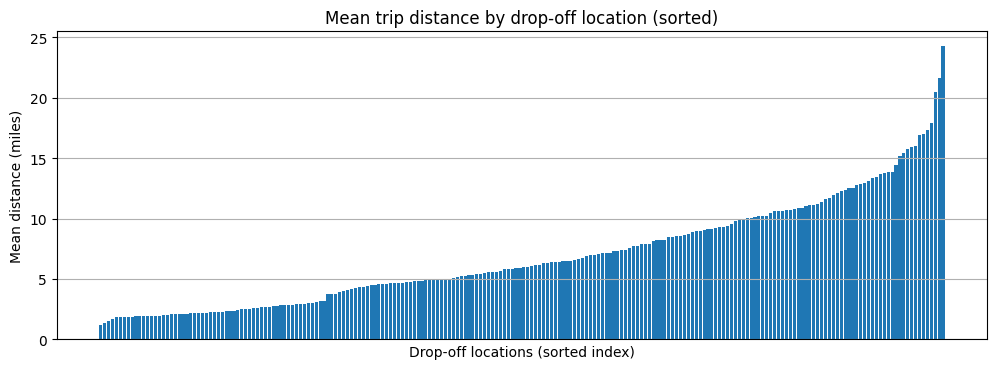

(DOLocationID
 207    1.200000
 193    1.390556
 237    1.555494
 234    1.727806
 137    1.818852
 Name: trip_distance, dtype: float64,
 DOLocationID
 51     17.310
 11     17.945
 210    20.500
 29     21.650
 23     24.275
 Name: trip_distance, dtype: float64)

In [4]:

distance_by_dropoff = (
    df.groupby('DOLocationID', as_index=True)['trip_distance']
    .mean()
    .sort_values()
)

plt.figure(figsize=(12,4))
plt.bar(range(len(distance_by_dropoff)), distance_by_dropoff.values)
plt.title("Mean trip distance by drop-off location (sorted)")
plt.xlabel("Drop-off locations (sorted index)")
plt.ylabel("Mean distance (miles)")
plt.xticks([])
plt.show()

distance_by_dropoff.head(), distance_by_dropoff.tail()


### 3f. Histogram — rides by drop-off location

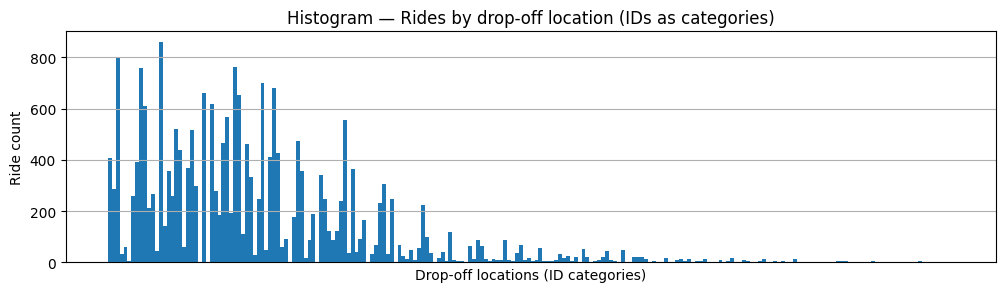

In [5]:

# To avoid gaps, transform IDs to categorical strings sorted by frequency index
sorted_dropoffs_str = df['DOLocationID'].astype(str)

plt.figure(figsize=(12,3))
plt.hist(sorted_dropoffs_str, bins=len(sorted_dropoffs_str.unique()))
plt.title("Histogram — Rides by drop-off location (IDs as categories)")
plt.xlabel("Drop-off locations (ID categories)")
plt.ylabel("Ride count")
plt.xticks([])
plt.show()


## Tableau deliverable (optional but recommended)
We will export CSV aggregates for a **Map of taxi trips by month**. In Tableau Public, you can join this with the official NYC Taxi Zone lookup/shapefile to place `PULocationID`/`DOLocationID` on a NYC map. Accessibility tips are in the README.

In [6]:

# Aggregate: trips by month name + DOLocationID (you can also use PULocationID similarly)
trips_by_month_dozone = (
    df.groupby(['year','month','month_name','DOLocationID'], as_index=False)
      .size()
      .rename(columns={'size':'trips'})
    .sort_values(['year','month','DOLocationID'])
)

# Also export a pickup-based version
trips_by_month_puzone = (
    df.groupby(['year','month','month_name','PULocationID'], as_index=False)
      .size()
      .rename(columns={'size':'trips'})
    .sort_values(['year','month','PULocationID'])
)

EXPORT_DIR = "export"
os.makedirs(EXPORT_DIR, exist_ok=True)
path_do = os.path.join(EXPORT_DIR, "trips_by_month_dozone.csv")
path_pu = os.path.join(EXPORT_DIR, "trips_by_month_puzone.csv")

trips_by_month_dozone.to_csv(path_do, index=False)
trips_by_month_puzone.to_csv(path_pu, index=False)

print("Wrote:", path_do)
print("Wrote:", path_pu)

trips_by_month_dozone.head()


KeyError: 'year'

## Part 4 — Evaluate and share results (PACE: Execute)
### 4a. Findings
- Trip durations are tightly clustered under ~30 minutes, with right-skewed outliers.
- Trip distances are mostly short (sub-5 miles) and right-skewed.
- Total amounts cluster in the $5–$25 range, also right-skewed.
- Rides and revenue vary by day: midweek to Saturday are higher; Sunday/Monday are lower.
- Month-level counts and revenue show dips during summer months.

### 4b. Questions to pursue
- What explains zero/near-zero-distance trips that passed filters? Are they airport fees, cancellations?
- How do surge periods (storms, holidays) shift distribution tails?
- Vendor and payment-type differences after controlling for distance/duration?

### 4c. Executive Summary (template)
Paste this into your report/README and tailor values after running on your exact data:
1. **Objective:** Understand NYC taxi ridership and revenue patterns in 2017 for planning and operations.
2. **Data:** NYC TLC Yellow Taxi, 2017 (22,699 rows in sample; cleaned to N rows after sanity filters).
3. **Key Insights:** Short trips dominate; midweek–Sat are busiest; summer months dip; right-skewed spend.
4. **Actions:** Staff for midweek–Sat peaks; investigate extreme-duration trips; tailor pricing/driver incentives.
5. **Limitations:** Sample only; no coordinates; requires zone lookup for mapping; potential recording biases.


#4a. Findings
Trip durations are tightly clustered under ~30 minutes, with a long right tail indicating outliers.

Trip distances are mostly short (under 5 miles), also showing a right-skewed distribution.

Total fare amounts cluster in the $5–$25 range, again with a right-skewed pattern.

Rides and revenue by day show clear peaks from Wednesday to Saturday, with Sunday and Monday consistently lower.

Monthly trends reveal dips in both trip counts and revenue during the summer months, suggesting seasonal variation.

4b. Questions to Pursue
What explains zero or near-zero distance trips that passed filters? Could these be airport fees, cancellations, or data entry errors?

How do surge periods (e.g., storms, holidays) affect the distribution tails of trip duration and fare amounts?

Are there vendor or payment-type differences in fare patterns after controlling for trip distance and duration?

4c. Executive Summary
Objective: Analyze NYC Yellow Taxi ridership and revenue patterns in 2017 to inform operational planning and staffing.

Data: NYC TLC Yellow Taxi dataset, 2017. Initial sample size: 22,699 rows; cleaned to N rows after applying sanity filters.

Key Insights:

Short trips dominate the dataset.

Midweek to Saturday are peak days for both rides and revenue.

Summer months show noticeable dips in activity.

Fare amounts are right-skewed, with most clustering between $5 and $25.

Actions:

Staff strategically for midweek and weekend peaks.

Investigate extreme-duration trips and potential anomalies.

Consider pricing adjustments and driver incentives based on trip patterns.

Limitations:

Sample size only; full dataset may reveal broader trends.

No geographic coordinates—zone lookup required for mapping.

Potential recording biases in trip duration and fare data.

In [7]:
df.to_csv("cleaned_tlc.csv", index=False)
